In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml(name="mnist_784")

print(mnist.keys())

data = mnist.data
labels = mnist.target


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])


(784,)
Image label: 1


C:\Users\Lukas\AppData\Local\Temp\ipykernel_11036\3189213581.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  side_length = int(np.sqrt(test_img.shape))


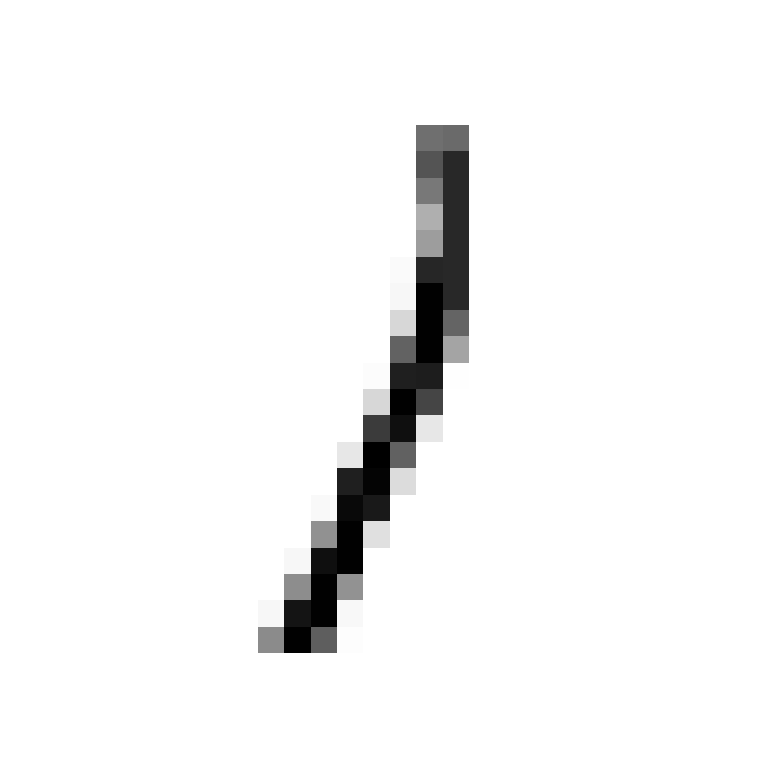

In [4]:
n = np.random.choice(np.arange(data.shape[0]+1))

test_img = data.iloc[n].values
test_label = mnist.target.iloc[n]

print(test_img.shape)

side_length = int(np.sqrt(test_img.shape))
reshaped_test_img = test_img.reshape(side_length, side_length)

print("Image label: " + str(test_label))

plt.imshow(reshaped_test_img, cmap="Greys")
plt.axis('off')
plt.show()

In [5]:
w1 = np.ones((784, 4)) * 0.01
z1 = np.dot(data, w1)
print(z1.shape)

w2 = np.ones((4, 10))
z2 = np.dot(z1, w2)
print(z2.shape)

(70000, 4)
(70000, 10)


In [5]:
# Activation functions

def sigmoid(x: np.ndarray) -> np.ndarray:
    return 1.0 / (1.0 + np.exp(-x))

def relu(x: np.ndarray) -> np.ndarray:
    return np.maximum(0, x)

def tanh(x: np.ndarray) -> np.ndarray:
    return np.tanh(x)

def leaky_relu(z: np.ndarray) -> np.ndarray:
    return np.where(z > 0, z, z * 0.01)

In [6]:
def softmax(z: np.ndarray) -> np.ndarray:
    e = np.exp(z - np.max(z))
    return e / np.sum(e, axis=0)

In [7]:
def normalize(x: np.ndarray) -> np.ndarray:
    return (x - np.min(x)) / (np.max(x) - np.min(x))

In [8]:
def one_hot_encode(x: np.ndarray, num_labels: int) -> np.ndarray:
    return np.eye(num_labels)[x]

In [9]:
def derivative(function_name: str, z: np.ndarray) -> np.ndarray:
    if function_name == "sigmoid":
        return sigmoid(z) * (1 - sigmoid(z))
    if function_name == "tanh":
        return 1 - np.square(tanh(z))
    if function_name == "relu":
        y = (z > 0) * 1
        return y
    if function_name == "leaky_relu":
        return  np.where(z > 0, 1, 0.01)
    return "No such activation"

In [10]:
class NN(object):
    def __init__(self, X: np.ndarray, y: np.ndarray, X_test: np.ndarray, y_test: np.ndarray, activation: str, num_labels: int, architecture: list[int]):
        self.X = normalize(X) # normalize training data in range 0,1
        assert np.all((self.X >= 0) | (self.X <= 1)) # test that normalize succeded
        self.X, self.X_test = X.copy(), X_test.copy()
        self.y, self.y_test = y.copy(), y_test.copy()
        self.layers = {} # define dict to store results of activation
        self.architecture = architecture # size of hidden layers as array  
        self.activation = activation # activation function
        assert self.activation in ["relu", "tanh", "sigmoid", "leaky_relu"]
        self.parameters = {}
        self.num_labels = num_labels
        self.m = X.shape[1]
        self.architecture.append(self.num_labels)
        self.num_input_features = X.shape[0]
        self.architecture.insert(0, self.num_input_features)
        self.L = len(architecture) 
        assert self.X.shape == (self.num_input_features, self.m)
        assert self.y.shape == (self.num_labels, self.m)
        
    def initialize_parameters(self):
        if self.activation == "relus":
            print(f"Initializing parameters for layer: {i} (He initialization).")

            fan_in = self.architecture[i - 1]  # number of inputs to layer i

            self.parameters["w" + str(i)] = (
                np.random.randn(self.architecture[i], fan_in) * np.sqrt(2.0 / fan_in)
            )
            self.parameters["b" + str(i)] = np.zeros((self.architecture[i], 1))
            
            return
        
        for i in range(1, self.L):
            print(f"Initializing parameters for layer: {i}.")
            self.parameters["w"+str(i)] = np.random.randn(self.architecture[i], self.architecture[i-1]) * 0.01
            self.parameters["b"+str(i)] = np.zeros((self.architecture[i], 1))
            
    def forward(self):
        params=self.parameters
        self.layers["a0"] = self.X
        for l in range(1, self.L-1):
            self.layers["z" + str(l)] = np.dot(params["w" + str(l)], 
                                               self.layers["a"+str(l-1)]) + params["b"+str(l)]
            self.layers["a" + str(l)] = eval(self.activation)(self.layers["z"+str(l)])
            assert self.layers["a"+str(l)].shape == (self.architecture[l], self.m)
        self.layers["z" + str(self.L-1)] = np.dot(params["w" + str(self.L-1)],
                                                  self.layers["a"+str(self.L-2)]) + params["b"+str(self.L-1)]
        self.layers["a"+str(self.L-1)] = softmax(self.layers["z"+str(self.L-1)])
        self.output = self.layers["a"+str(self.L-1)]
        assert self.output.shape == (self.num_labels, self.m)
        assert all([s for s in np.sum(self.output, axis=1)])        
        
        cost = - np.sum(self.y * np.log(self.output + 0.000000001))

        return cost, self.layers
    
    def backpropagate(self):
        derivatives = {}
        dZ = self.output - self.y
        assert dZ.shape == (self.num_labels, self.m)
        dW = np.dot(dZ, self.layers["a" + str(self.L-2)].T) / self.m
        dB = np.sum(dZ, keepdims=True) / self.m
        dAPrev = np.dot(self.parameters["w" + str(self.L-1)].T, dZ)
        derivatives["dW" + str(self.L-1)] = dW
        derivatives["db" + str(self.L-1)] = dB
            
        for i in range(self.L - 2, 0, -1):
            dZ = dAPrev * derivative(self.activation, self.layers["z" + str(i)])
            dW = 1. / self.m * np.dot(dZ, self.layers["a" + str(i-1)].T)
            dB = 1. / self.m * np.sum(dZ, axis=1, keepdims=True)
            if i > 1:
                dAPrev = np.dot(self.parameters["w" + str(i)].T, (dZ))
            derivatives["dW" + str(i)] = dW
            derivatives["db" + str(i)] = dB
        self.derivates = derivatives
        
        return self.derivates
    
    
    def fit(self, lr=0.01, epochs=1000):
        self.costs = [] 
        self.initialize_parameters()
        self.accuracies = {"train": [], "test": []}
        for epoch in tqdm(range(epochs), colour="BLUE"):
            cost, cache = self.forward()
            self.costs.append(cost)
            derivatives = self.backpropagate()            
            for layer in range(1, self.L):
                self.parameters["w"+str(layer)] = self.parameters["w"+str(layer)] - lr * derivatives["dW" + str(layer)]
                self.parameters["b"+str(layer)] = self.parameters["b"+str(layer)] - lr * derivatives["db" + str(layer)]            
            train_accuracy = self.accuracy(self.X, self.y)
            test_accuracy = self.accuracy(self.X_test, self.y_test)
            if epoch % 10 == 0:
                print(f"Epoch: {epoch:3d} | Cost: {cost:.3f} | Accuracy: {train_accuracy:.3f}")
            self.accuracies["train"].append(train_accuracy)
            self.accuracies["test"].append(test_accuracy)
        print("Training terminated")
        
        
    
    def predict(self, x):
        params = self.parameters
        n_layers = self.L - 1
        values = [x]
        for l in range(1, n_layers):
            z = np.dot(params["w" + str(l)], values[l-1]) + params["b" + str(l)]
            a = eval(self.activation)(z)
            values.append(a)
        z = np.dot(params["w"+str(n_layers)], values[n_layers-1]) + params["b"+str(n_layers)]
        a = softmax(z)
        if x.shape[1]>1:
            ans = np.argmax(a, axis=0)
        else:
            ans = np.argmax(a)
        return ans
    
    
    def accuracy(self, X, y):
        P = self.predict(X)
        return sum(np.equal(P, np.argmax(y, axis=0))) / y.shape[1]*100
    
    def plot_cost(self, lr):
        plt.figure(figsize=(8, 4))
        plt.plot(np.arange(0, len(self.costs)), self.costs, lw=1, color="orange")
        plt.title(f"Learning rate: {lr}\nFinal Cost: {self.costs[-1]:.5f}", fontdict={
        "family":"sans-serif", 
        "size": "12"})
        plt.xlabel("Epoch")
        plt.ylabel("Cost")
        plt.show()
    
            

In [11]:
# import pickle


# with open("mnist.pickle", 'rb') as f:
#     mnist = pickle.load(f)
# data = mnist.data
# labels = mnist.target

train_test_split_no = 60000
X_train = data.values[:train_test_split_no].T
y_train = labels[:train_test_split_no].values.astype(int)
y_train = one_hot_encode(y_train, 10).T
X_test = data.values[train_test_split_no:].T
y_test = labels[train_test_split_no:].values.astype(int)
y_test = one_hot_encode(y_test, 10).T
X_train.shape, X_test.shape

((784, 60000), (784, 10000))

Initializing parameters for layer: 1.
Initializing parameters for layer: 2.
Initializing parameters for layer: 3.


  1%|          | 1/100 [00:00<01:33,  1.06it/s]

Epoch:   0 | Cost: 138887.918 | Accuracy: 8.293


 11%|█         | 11/100 [00:10<01:22,  1.08it/s]

Epoch:  10 | Cost: 135704.336 | Accuracy: 24.395


 21%|██        | 21/100 [00:19<01:12,  1.09it/s]

Epoch:  20 | Cost: 131076.807 | Accuracy: 36.297


 31%|███       | 31/100 [00:28<01:02,  1.11it/s]

Epoch:  30 | Cost: 122822.533 | Accuracy: 45.037


 41%|████      | 41/100 [00:37<00:52,  1.12it/s]

Epoch:  40 | Cost: 109716.251 | Accuracy: 56.680


 51%|█████     | 51/100 [00:46<00:44,  1.11it/s]

Epoch:  50 | Cost: 91618.281 | Accuracy: 64.817


 61%|██████    | 61/100 [00:55<00:34,  1.13it/s]

Epoch:  60 | Cost: 72741.974 | Accuracy: 71.512


 71%|███████   | 71/100 [01:04<00:25,  1.12it/s]

Epoch:  70 | Cost: 58491.701 | Accuracy: 76.123


 81%|████████  | 81/100 [01:13<00:17,  1.10it/s]

Epoch:  80 | Cost: 48906.609 | Accuracy: 78.923


 91%|█████████ | 91/100 [01:23<00:08,  1.05it/s]

Epoch:  90 | Cost: 42602.269 | Accuracy: 80.830


100%|██████████| 100/100 [01:32<00:00,  1.08it/s]

Training terminated


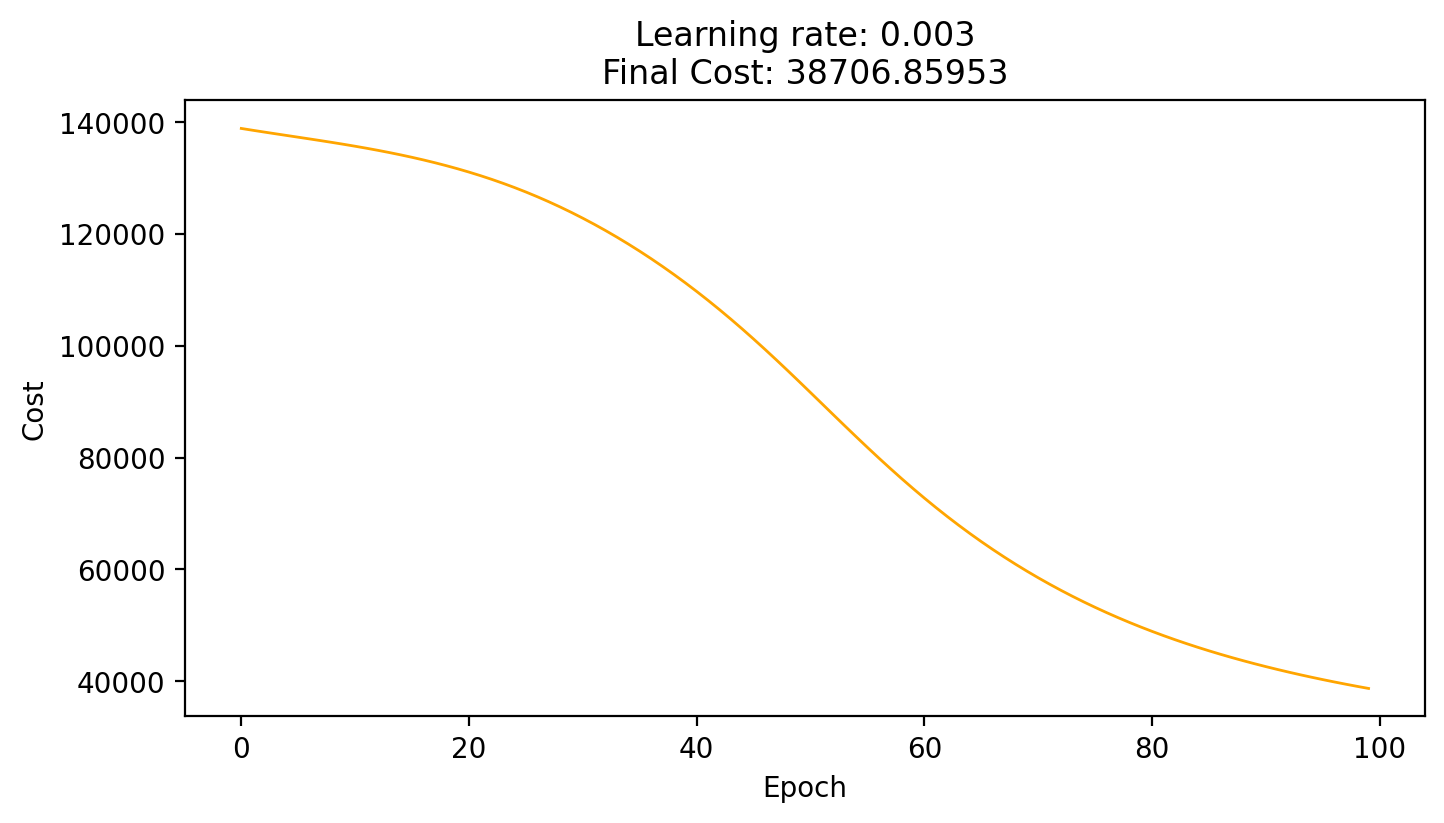

In [12]:
PARAMS = [X_train, y_train, X_test, y_test, "relu", 10, [128, 32]]
nn_relu = NN(*PARAMS)
epochs_relu = 100
lr_relu = 0.003
nn_relu.fit(lr=lr_relu, epochs=epochs_relu)
nn_relu.plot_cost(lr_relu)

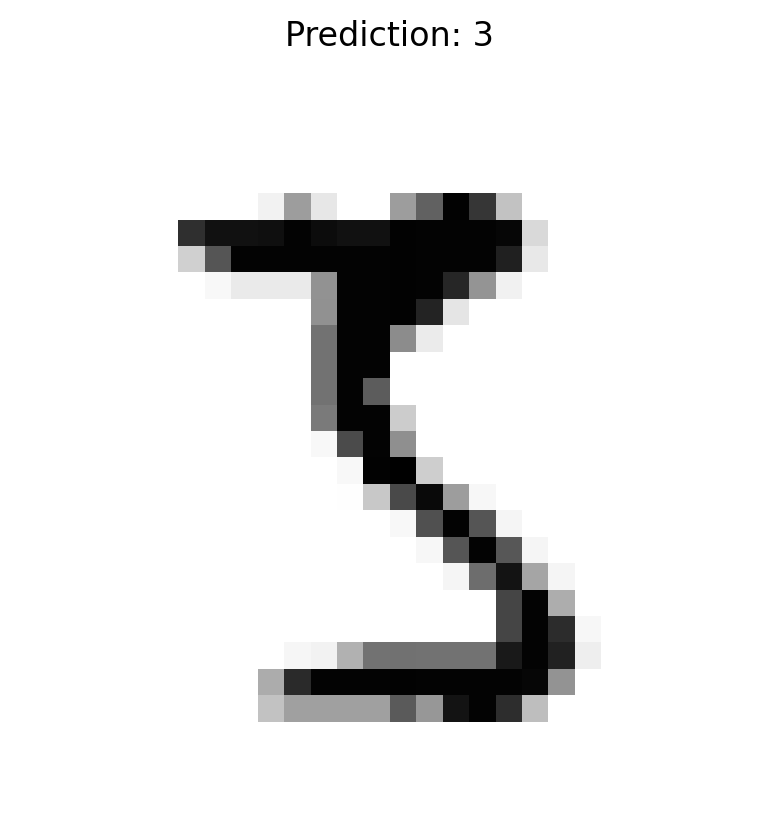

In [31]:
from matplotlib.pylab import randint


example_index = randint(1, 6000)
plt.imshow(X_test[:, example_index].reshape(28,28), cmap="Greys")
prediction = nn_relu.predict(X_test[:, example_index].reshape((X_test.shape[0], 1)))
plt.title("Prediction: " + str(prediction))
plt.axis('off')
plt.show()